In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from cooltools.lib import numutils

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

In [2]:
from akita_utils.format_io import h5_to_df

In [3]:
import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from reading_averaging_utils import (read_and_average_virtual_exp, average_stat_over_targets, average_stat_over_backgrounds)
from analysis_utils import split_by_percentile_groups

2024-02-13 15:52:04.867680: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 15:52:04.904824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 15:52:04.904876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 15:52:04.906341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 15:52:04.915293: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# stat metric the analysis is based on
stat_of_analysis_interest = "SCD"
data_dir = "/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_number"

In [5]:
# model 0, bg 0
df_m0_bg0 = h5_to_df(data_dir+"/model0_right40_bg0.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=["insertion_SCD", "disruption_SCD"]) 
df_m0_bg0_tg = average_stat_over_targets(df_m0_bg0, model_index=0, head_index=1, stat=stat_of_analysis_interest)

In [6]:
# model 0, bg 0
df_m0_bg1 = h5_to_df(data_dir+"/model0_right40_bg1.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=["insertion_SCD", "disruption_SCD"]) 
df_m0_bg1_tg = average_stat_over_targets(df_m0_bg1, model_index=0, head_index=1, stat=stat_of_analysis_interest)

In [7]:
# model 0, bg 0
df_m0_bg2 = h5_to_df(data_dir+"/model0_right40_bg2.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=["insertion_SCD", "disruption_SCD"]) 
df_m0_bg2_tg = average_stat_over_targets(df_m0_bg2, model_index=0, head_index=1, stat=stat_of_analysis_interest)

In [8]:
df_m0_bg0 = df_m0_bg0.rename(columns={"SCD_m0": "SCD_m0_bg0"})
df_m0_bg1 = df_m0_bg1.rename(columns={"SCD_m0": "SCD_m0_bg1"})
df_m0_bg2 = df_m0_bg2.rename(columns={"SCD_m0": "SCD_m0_bg2"})

In [9]:
# model 1, bg 0
df_m1_bg0 = h5_to_df(data_dir+"/model1_right40_bg0.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=["insertion_SCD", "disruption_SCD"]) 
df_m1_bg0_tg = average_stat_over_targets(df_m1_bg0, model_index=1, head_index=1, stat=stat_of_analysis_interest)

In [10]:
# model 1, bg 1
df_m1_bg1 = h5_to_df(data_dir+"/model1_right40_bg0.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=["insertion_SCD", "disruption_SCD"]) 
df_m1_bg1_tg = average_stat_over_targets(df_m1_bg1, model_index=1, head_index=1, stat=stat_of_analysis_interest)

In [11]:
# model 1, bg 2
df_m1_bg2 = h5_to_df(data_dir+"/model1_right40_bg0.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=["insertion_SCD", "disruption_SCD"]) 
df_m1_bg2_tg = average_stat_over_targets(df_m1_bg2, model_index=1, head_index=1, stat=stat_of_analysis_interest)

In [12]:
df_m1_bg0 = df_m1_bg0.rename(columns={"SCD_m1": "SCD_m1_bg0"})
df_m1_bg1 = df_m1_bg1.rename(columns={"SCD_m1": "SCD_m1_bg1"})
df_m1_bg2 = df_m1_bg2.rename(columns={"SCD_m1": "SCD_m1_bg2"})

In [13]:
df_m0_bg0["SCD_m0_bg1"] = df_m0_bg1["SCD_m0_bg1"]
df_m0_bg0["SCD_m0_bg2"] = df_m0_bg2["SCD_m0_bg2"]

df_m0_bg0["SCD_m1_bg0"] = df_m1_bg0["SCD_m1_bg0"]
df_m0_bg0["SCD_m1_bg1"] = df_m1_bg1["SCD_m1_bg1"]
df_m0_bg0["SCD_m1_bg2"] = df_m1_bg2["SCD_m1_bg2"]

In [14]:
del df_m0_bg1
del df_m0_bg2
del df_m1_bg0
del df_m1_bg1
del df_m1_bg2

In [15]:
df_m0_bg0["SCD_m0"] = df_m0_bg0[["SCD_m0_bg0", "SCD_m0_bg1", "SCD_m0_bg2"]].mean(axis=1)

In [16]:
df_m0_bg0["SCD_m1"] = df_m0_bg0[["SCD_m1_bg0", "SCD_m1_bg1", "SCD_m1_bg2"]].mean(axis=1)

In [18]:
for model_index in range(2):
    for background_index_0 in range(3):
        for background_index_1 in range(3):
            if background_index_0 > background_index_1:
                print("Model", model_index)
                print("\t - Correlation between backgrounds: ", background_index_0, background_index_1)
                perm_corr = round(stats.pearsonr(df_m0_bg0[f"SCD_m0_bg{background_index_0}"], df_m0_bg0[f"SCD_m0_bg{background_index_1}"]).statistic, 4)
                print("\t", perm_corr)

Model 0
	 - Correlation between backgrounds:  1 0
	 0.998
Model 0
	 - Correlation between backgrounds:  2 0
	 0.9946
Model 0
	 - Correlation between backgrounds:  2 1
	 0.9928
Model 1
	 - Correlation between backgrounds:  1 0
	 0.998
Model 1
	 - Correlation between backgrounds:  2 0
	 0.9946
Model 1
	 - Correlation between backgrounds:  2 1
	 0.9928


In [19]:
# Correlation between models
round(stats.pearsonr(df_m0_bg0[f"SCD_m0"], df_m0_bg0[f"SCD_m1"]).statistic, 4)

0.9679

In [20]:
df_m0_bg0["SCD"] = df_m0_bg0[["SCD_m0", "SCD_m1"]].mean(axis=1)

In [21]:
def get_num_sites(row):
    return len(row["orientation"])

In [22]:
df_m0_bg0["number"] = df_m0_bg0.apply(get_num_sites, axis=1)

In [23]:
df_split_SCDins = split_by_percentile_groups(df_m0_bg0, column_to_split="insertion_SCD", num_classes=5, 
                               upper_percentile=100, lower_percentile=0, 
                               category_colname="insSCD_group")

In [24]:
number_df = df_split_SCDins.groupby(["insSCD_group", "number"]).agg({"SCD": "mean"}).reset_index()

In [25]:
color_dict = {"Group_0": "#9fc2e0",
              "Group_1": "#6da3d0",
              "Group_2":"#3b7fb9", 
              "Group_3":"#2d618e", 
              "Group_4":"#1d3f5c"}

In [26]:
max_num_sites = 40

## Plot with sites splited into 5 groups by percentiles

Text(0, 0.5, 'Insertion SCD')

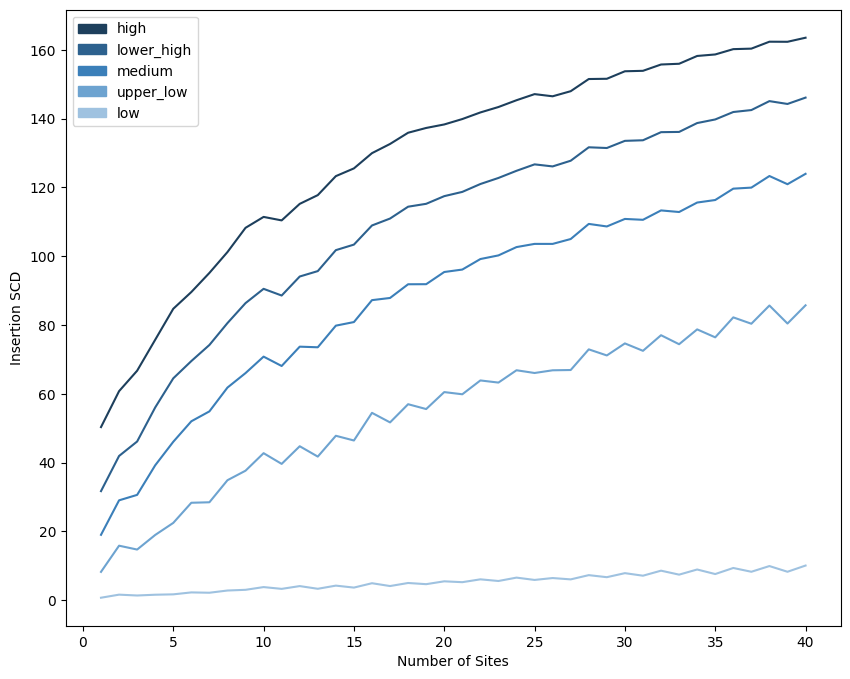

In [27]:
plt.figure(figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, number_df[(number_df["insSCD_group"] == group)]["SCD"], 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="high")
gr3_patch = mpatches.Patch(color="#2d618e", label="lower_high")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="medium")
gr1_patch = mpatches.Patch(color="#6da3d0", label="upper_low")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="low")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")
# plt.legend(loc="upper left")

## Plot with smoothed lines

In [28]:
bin_size = 11

Text(0, 0.5, 'Insertion SCD')

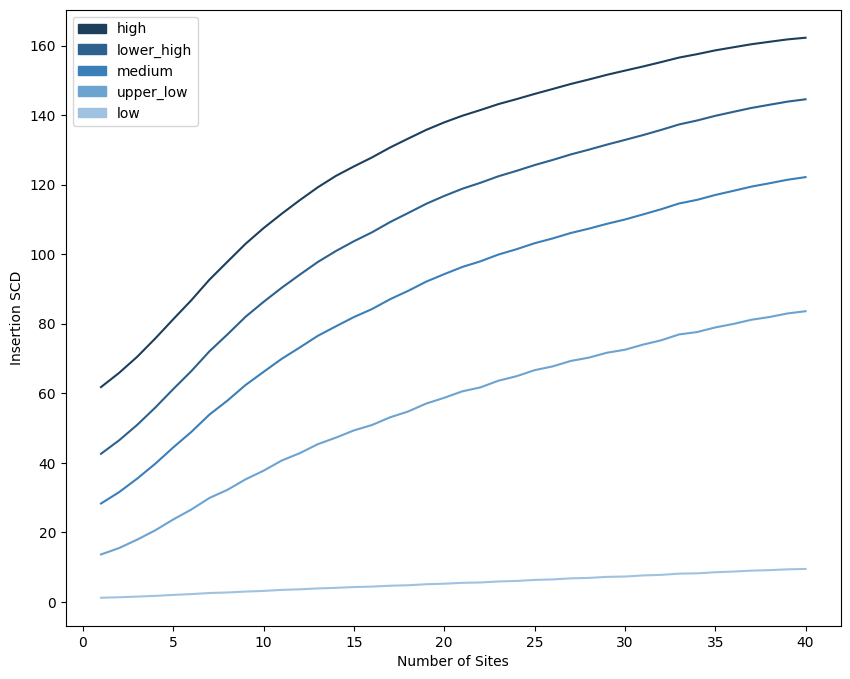

In [29]:
plt.figure(figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size), 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="high")
gr3_patch = mpatches.Patch(color="#2d618e", label="lower_high")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="medium")
gr1_patch = mpatches.Patch(color="#6da3d0", label="upper_low")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="low")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")
# plt.legend(loc="upper left")

## Plot with smoothed lines and 25-75 percentile bands

In [30]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [31]:
insSCDpercentiles_df = df_split_SCDins.groupby(["insSCD_group", "number"])["SCD"].agg(
    percentile25 = percentile(25), percentile75 = percentile(75)).reset_index()

Text(0, 0.5, 'Insertion SCD')

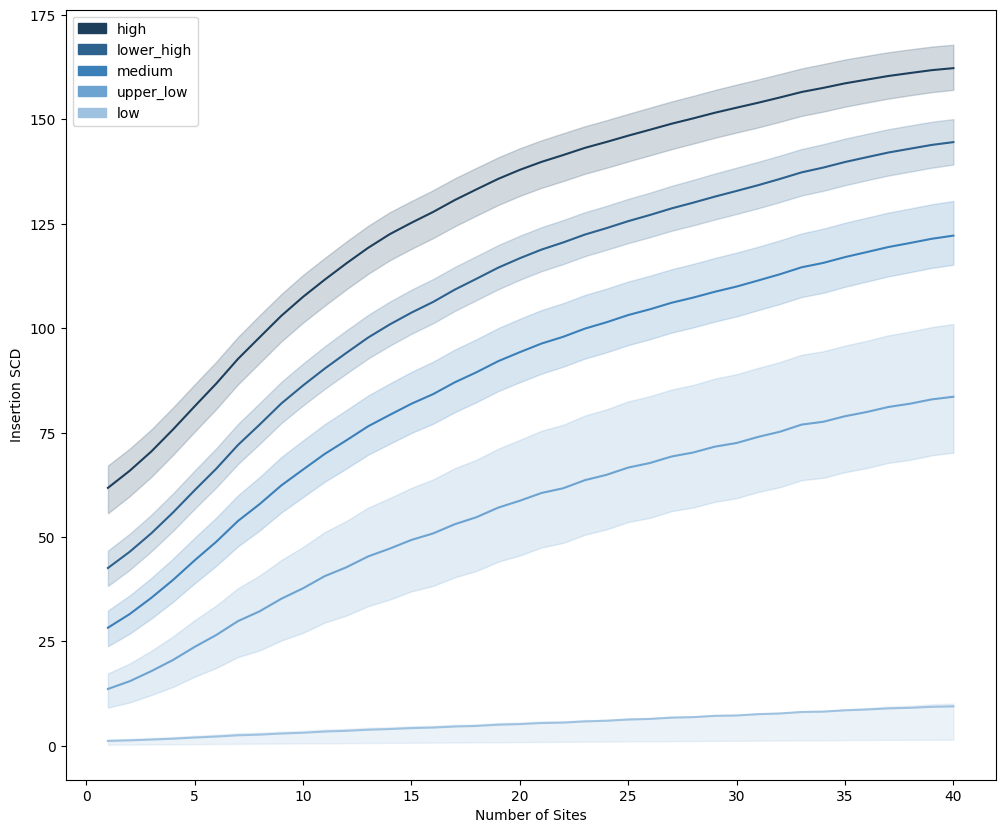

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

gr4_patch = mpatches.Patch(color="#1d3f5c", label="high")
gr3_patch = mpatches.Patch(color="#2d618e", label="lower_high")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="medium")
gr1_patch = mpatches.Patch(color="#6da3d0", label="upper_low")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="low")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")
# plt.legend(loc="upper left")

## Plotting 10 random sites from high, medium, low insertion_SCD group

In [33]:
num_sites = 10
ten_high = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_4"].start.unique(), size=num_sites)
ten_medium = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_2"].start.unique(), size=num_sites)
ten_low = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_0"].start.unique(), size=num_sites)

Text(0, 0.5, 'Insertion SCD')

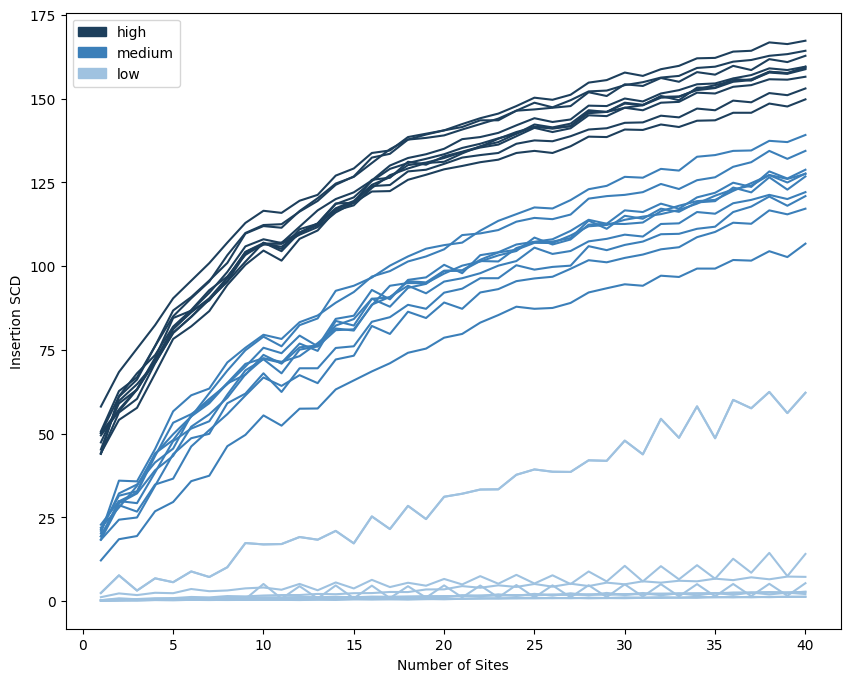

In [34]:
plt.figure(figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for start_pos in ten_high:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="number")["SCD"], color="#1d3f5c")

for start_pos in ten_medium:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="number")["SCD"], color="#3b7fb9")

for start_pos in ten_low:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="number")["SCD"], color="#9fc2e0")

gr4_patch = mpatches.Patch(color="#1d3f5c", label="high")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="medium")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="low")
plt.legend(handles=[gr4_patch, gr2_patch, gr0_patch], loc="upper left")

# # plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")

## Plot with smoothed trends of 5 classes overlayed with 10 lines randomly chosen from the 'High'

Text(0, 0.5, 'Insertion SCD')

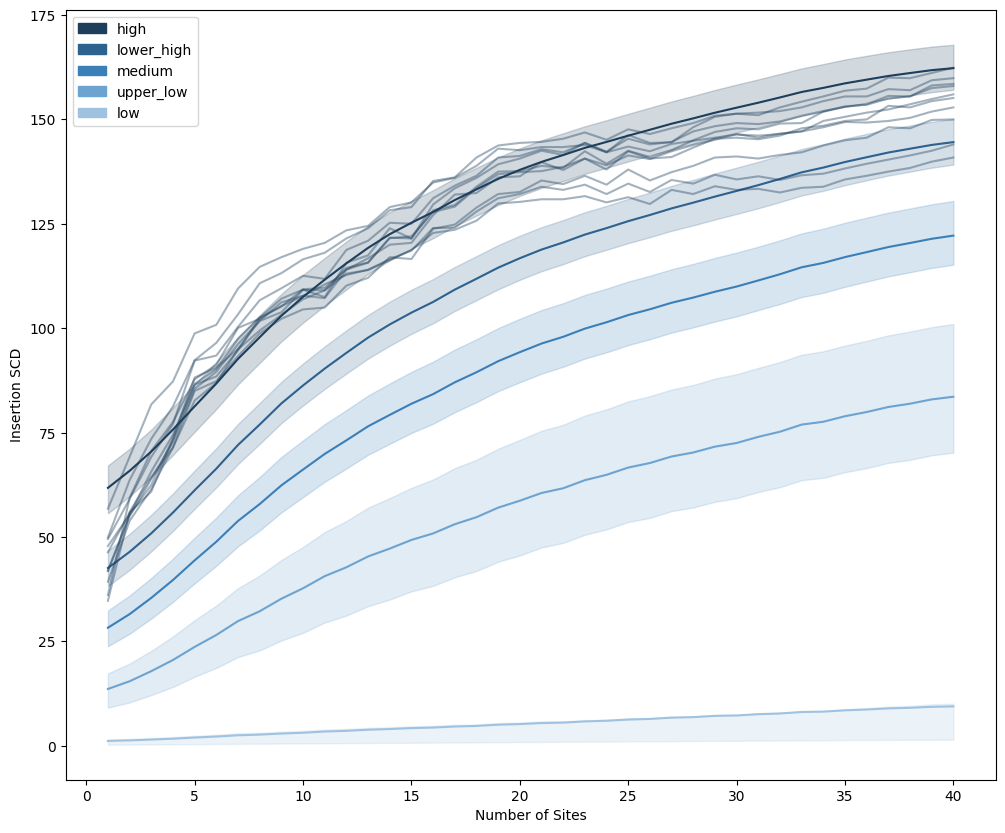

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

for start_pos in ten_high:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="number")["SCD_m0"], color="#1d3f5c", alpha=0.4)

gr4_patch = mpatches.Patch(color="#1d3f5c", label="high")
gr3_patch = mpatches.Patch(color="#2d618e", label="lower_high")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="medium")
gr1_patch = mpatches.Patch(color="#6da3d0", label="upper_low")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="low")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")
# plt.legend(loc="upper left")
